In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestCentroid
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.svm import SVC
import networkx as nx 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

###
Import Data & Check for Statistics
###

In [420]:
df = pd.read_csv('/Users/ryan/Documents/Polyu 4.1/comp4433/heart_attack/data/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [421]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None
              age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.62376

In [422]:
#Split to training and testing data
df_train, df_test = train_test_split(df, test_size=0.2)

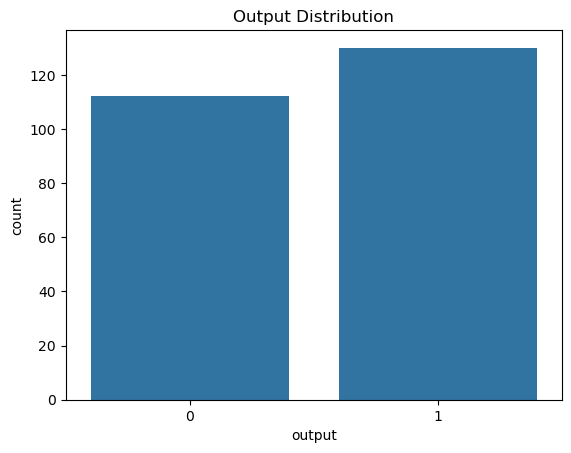

In [423]:
sns.countplot(x='output', data=df_train)
plt.title("Output Distribution")
plt.show()


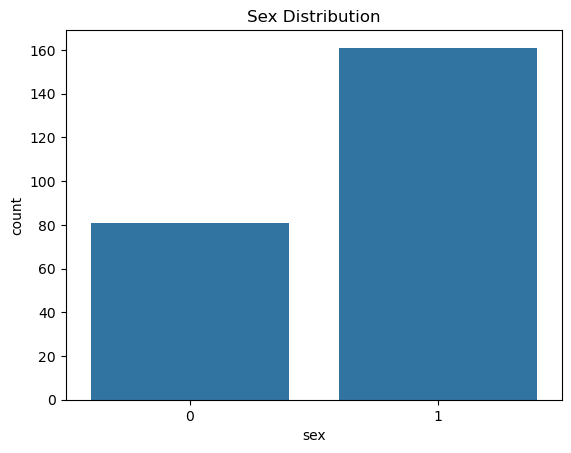

In [424]:
sns.countplot(x='sex', data=df_train)
plt.title("Sex Distribution")
plt.show()

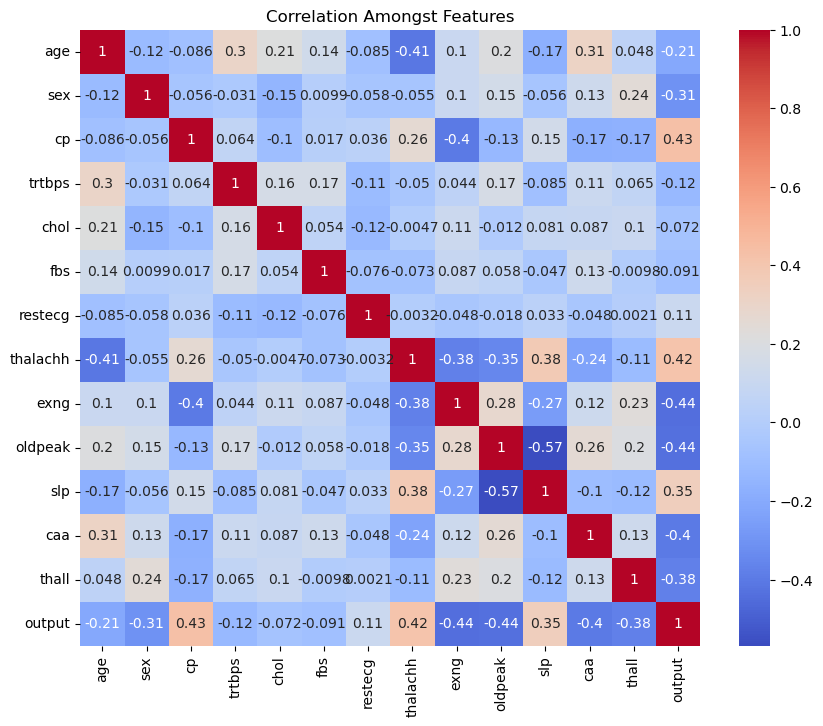

In [425]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Amongst Features")
plt.show()


###
Outliers
###

In [426]:
features = df.select_dtypes(include=['int64', 'float64']).columns
features = features.drop('output')
features

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall'],
      dtype='object')

In [427]:
#Identify outliers by using IQR method.
Q1 = df_train[features].quantile(0.25)
Q3 = df_train[features].quantile(0.75)
IQR = Q3 - Q1

#Boolean DataFrame indicating whether a value is an outlier
outliers = (df_train[features] < (Q1 - 1.5 * IQR)) | (df_train[features] > (Q3 + 1.5 * IQR))

#Print number of outliers in each column
print(outliers.sum())

#Filter rows that are outliers in any column
df_train_outliers = df_train[outliers.any(axis=1)]
print("Number of rows with outliers in any feature:", len(df_train_outliers))

age          0
sex          0
cp           0
trtbps       7
chol         3
fbs         31
restecg      0
thalachh     1
exng         0
oldpeak      1
slp          0
caa         21
thall        2
dtype: int64
Number of rows with outliers in any feature: 56


In [428]:
def outlier_analysis(train_df : pd.DataFrame, test_df : pd.DataFrame, feature : str): 
    #Scatterplot of the 50 highest value in the train-set and test-set
    fig, axes = plt.subplots(1,3, figsize = (12,4))
    sns.scatterplot(x = train_df[feature].sort_values(ascending=False)[:50], y=[10] * len(train_df[:50]), label = "Train data", color = "blue", ax = axes[0])
    sns.scatterplot(x=test_df[feature].sort_values(ascending=False)[:50], y=[20] * len(test_df[:50]), label = "Test data",color = "red", ax = axes[0])
    axes[0].set_title(f"Fig1: Scatter Plot of {feature} comparing train and test data", fontsize = 10)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    #CDF plot of both datasets.  
    sns.ecdfplot(x= train_df[feature], color = "blue", label="Train data", ax = axes[1])
    sns.ecdfplot(test_df[feature], label="Test data", color="red", ax=axes[1])
    axes[1].set_title(f"Fig2: CDF of {feature}", fontsize = 10)
    axes[1].grid(True, linestyle="--", alpha=0.5)
    outlier_threshold = train_df[feature].quantile(0.99)
    axes[1].axvspan(outlier_threshold, train_df[feature].max(), color="red", alpha=0.1, label="Potential Outliers")
    axes[1].legend()
    
    #Scatterplot of all datapoints in trainset with respect to the SalePrice
    sns.scatterplot(train_df, x = feature, y = "output", ax = axes[2])
    axes[2].set_title(f"Fig 3: Scatterplot of {feature} with respect to Output", fontsize = 10)
    plt.tight_layout()
    plt.show()

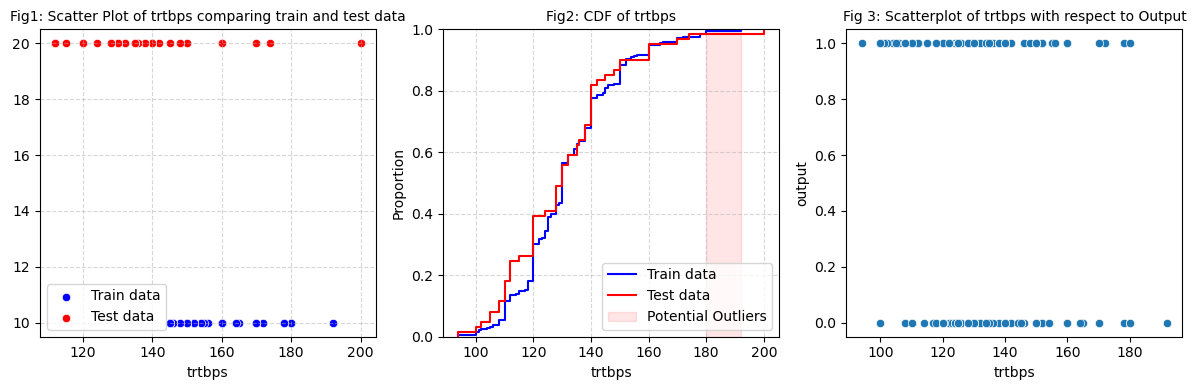

In [429]:
outlier_analysis(df_train, df_test, 'trtbps')

Remove values above 180

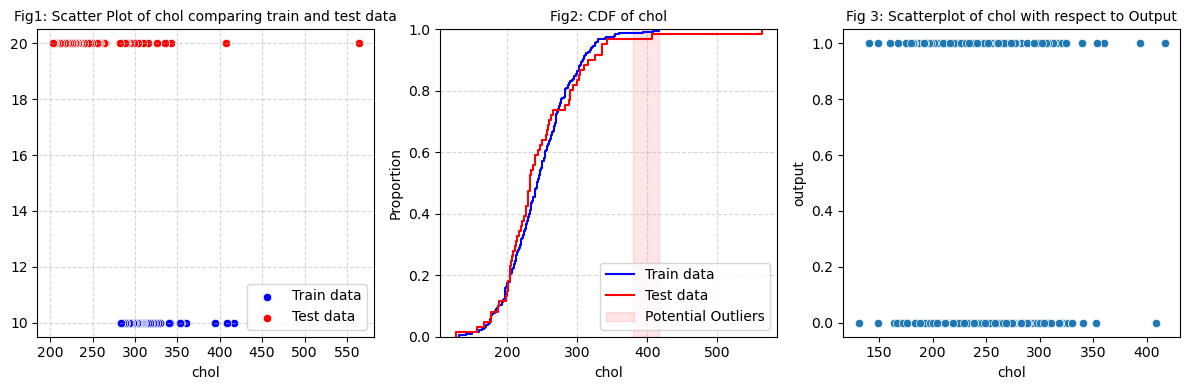

In [430]:
outlier_analysis(df_train, df_test, 'chol')

Remove chol values above 500

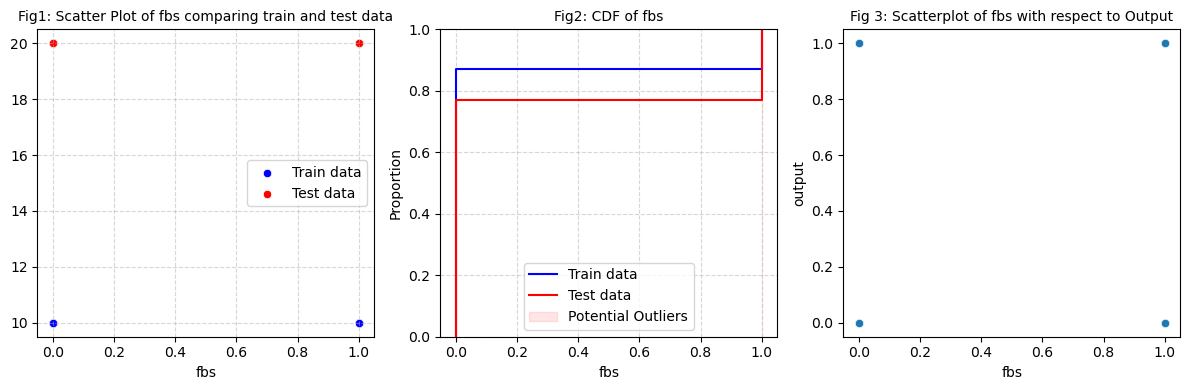

In [431]:
outlier_analysis(df_train, df_test, 'fbs')

No need to remove

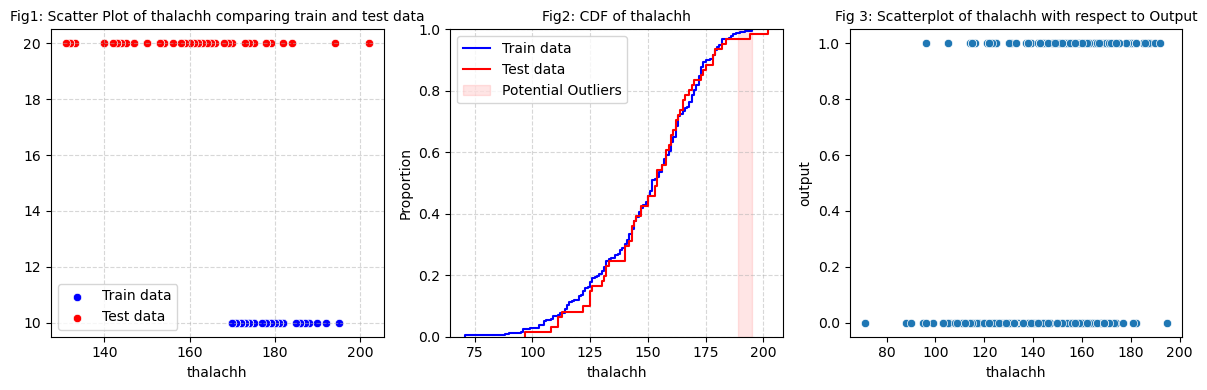

In [432]:
outlier_analysis(df_train, df_test, 'thalachh')

Remove values above 200

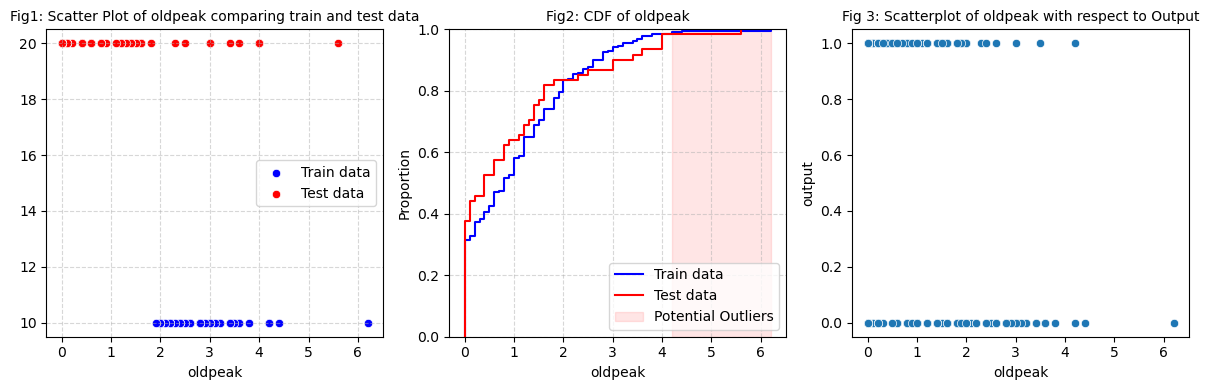

In [433]:
outlier_analysis(df_train, df_test, 'oldpeak')

Remove values above 5

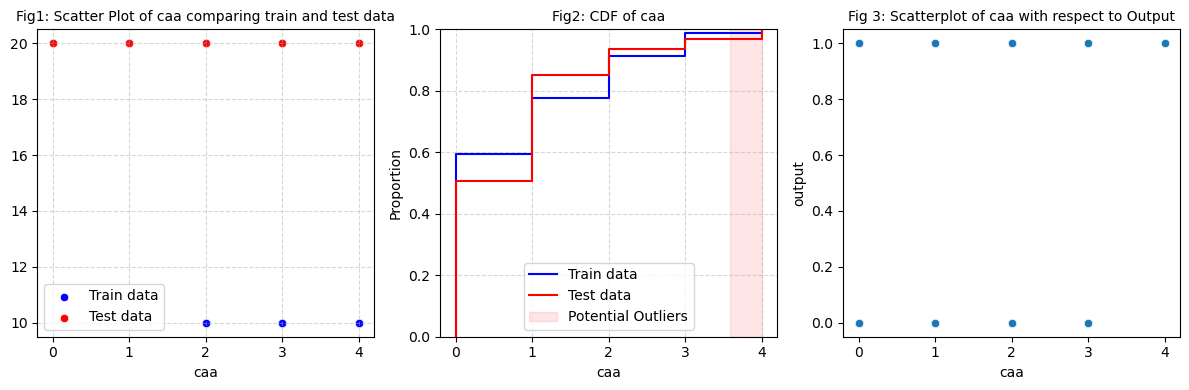

In [434]:
outlier_analysis(df_train, df_test, 'caa')

No need to remove

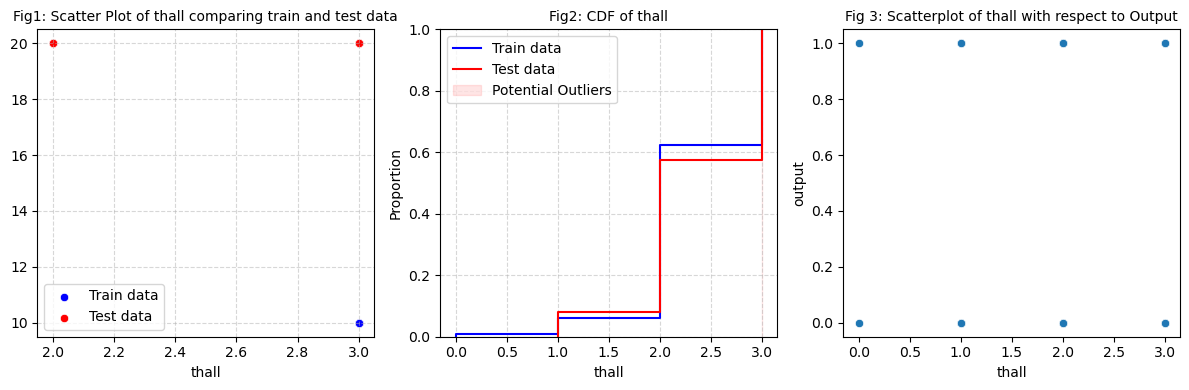

In [435]:
outlier_analysis(df_train, df_test, 'thall')

No need to remove

In [436]:
#Remove outliers
df_train = df_train[df_train['trtbps'] <= 180]
df_train = df_train[df_train['chol'] <= 500]
df_train = df_train[df_train['thalachh'] <= 200]
df_train = df_train[df_train['oldpeak'] <= 5]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 56 to 207
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       240 non-null    int64  
 1   sex       240 non-null    int64  
 2   cp        240 non-null    int64  
 3   trtbps    240 non-null    int64  
 4   chol      240 non-null    int64  
 5   fbs       240 non-null    int64  
 6   restecg   240 non-null    int64  
 7   thalachh  240 non-null    int64  
 8   exng      240 non-null    int64  
 9   oldpeak   240 non-null    float64
 10  slp       240 non-null    int64  
 11  caa       240 non-null    int64  
 12  thall     240 non-null    int64  
 13  output    240 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 28.1 KB


Feature Engineering

In [437]:
#Split & Scale Data
X_train = df_train.drop('output', axis=1)
y_train = df_train['output']

X_test = df_test.drop('output', axis=1)
y_test = df_test['output']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [438]:
#Apply PCA, keep 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
print("Number of PCA components selected:", pca.n_components_)

Number of PCA components selected: 12


In [439]:
#Transform test set using PCA as well
X_test_pca = pca.transform(X_test_scaled)

In [440]:
#Original features weights after PCA
original_features = X_train.columns  
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=original_features)
print(loadings)

               PC1       PC2       PC3       PC4       PC5       PC6  \
age      -0.315538  0.438320  0.081154 -0.123785  0.252662  0.002047   
sex      -0.126417 -0.391443  0.015274  0.612045  0.122902 -0.072429   
cp        0.267310  0.187322  0.498166  0.254004 -0.006888  0.244548   
trtbps   -0.175689  0.436141  0.179058  0.240343 -0.128024  0.330808   
chol     -0.117840  0.402731 -0.469191 -0.026296 -0.115672  0.351896   
fbs      -0.126637  0.277981  0.119098  0.308054 -0.020455 -0.416914   
restecg   0.070098 -0.197454  0.187211 -0.335912  0.600322  0.388807   
thalachh  0.421020  0.021546 -0.105684  0.273406 -0.114714  0.163881   
exng     -0.371412 -0.177562 -0.281883 -0.138707 -0.222913 -0.067103   
oldpeak  -0.410875 -0.145593  0.323038  0.043983 -0.132867  0.193446   
slp       0.364448  0.173831 -0.390558  0.157599  0.313977 -0.075684   
caa      -0.283858  0.129131 -0.070297  0.201349  0.585166 -0.242853   
thall    -0.223327 -0.225397 -0.301860  0.343608  0.094500  0.49

Models

In [441]:
#Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)

print("Classification Approach (Random Forest):")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Classification Approach (Random Forest):
Accuracy: 0.8524590163934426
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82        26
           1       0.86      0.89      0.87        35

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

Confusion Matrix:
 [[21  5]
 [ 4 31]]


In [442]:
#K Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

train_clusters = kmeans.labels_

cluster_labels = {}
for cluster_id in np.unique(train_clusters):
    #Select rows belonging to this cluster
    cluster_points = y_train[train_clusters == cluster_id]
    #Find the majority class in this cluster
    majority_class = cluster_points.value_counts().idxmax()
    cluster_labels[cluster_id] = majority_class

print("Cluster to class mapping (based on training majority):", cluster_labels)

#Assign clusters to test data
test_clusters = kmeans.predict(X_test_pca)
#Map cluster assignments to classes
y_pred_cluster = [cluster_labels[c] for c in test_clusters]

print("Clustering Approach (KMeans):")
print("Accuracy:", accuracy_score(y_test, y_pred_cluster))
print("Classification Report:\n", classification_report(y_test, y_pred_cluster))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cluster))

Cluster to class mapping (based on training majority): {0: 0, 1: 1}
Clustering Approach (KMeans):
Accuracy: 0.8360655737704918
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.82      0.91      0.86        35

    accuracy                           0.84        61
   macro avg       0.84      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61

Confusion Matrix:
 [[19  7]
 [ 3 32]]


In [443]:
#AGNES Clustering
agg_clust = AgglomerativeClustering(n_clusters=2)

# Fit on training data and predict cluster labels
train_clusters_agg = agg_clust.fit_predict(X_train_pca)

# Map clusters to classes based on majority voting in the training set
cluster_labels_agg = {}
for cluster_id in np.unique(train_clusters_agg):
    # Get the majority class in each cluster
    majority_class = y_train[train_clusters_agg == cluster_id].mode()[0]
    cluster_labels_agg[cluster_id] = majority_class

print("\nAgglomerative Clustering Cluster to Class Mapping:", cluster_labels_agg)

# Assign clusters to test data
# Since AgglomerativeClustering does not have a predict method, we'll use Nearest Centroid
# to assign test samples to the nearest cluster centroid based on training data

# Calculate centroids of each cluster from training data
centroids_agg = {}
for cluster_id in np.unique(train_clusters_agg):
    centroids_agg[cluster_id] = X_train_pca[train_clusters_agg == cluster_id].mean(axis=0)

# Function to assign cluster based on nearest centroid
def assign_cluster_agg(x, centroids):
    distances = {cid: np.linalg.norm(x - centroid) for cid, centroid in centroids.items()}
    return min(distances, key=distances.get)

# Assign clusters to test data
test_clusters_agg = [assign_cluster_agg(x, centroids_agg) for x in X_test_pca]

# Map cluster assignments to class labels
y_pred_agg = [cluster_labels_agg[c] for c in test_clusters_agg]

print("\nClustering Approach (Agglomerative Clustering):")
print("Accuracy:", accuracy_score(y_test, y_pred_agg))
print("Classification Report:\n", classification_report(y_test, y_pred_agg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_agg))


Agglomerative Clustering Cluster to Class Mapping: {0: 0, 1: 1}

Clustering Approach (Agglomerative Clustering):
Accuracy: 0.7704918032786885
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.80      0.80      0.80        35

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61

Confusion Matrix:
 [[19  7]
 [ 7 28]]


In [444]:
#Compare results for each model
summary = pd.DataFrame({
    'Approach': ['K-Means Clustering', 'Random Forest', 'Agglomerative Clustering'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_cluster),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_agg),
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_cluster, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, y_pred_agg, output_dict=True)['weighted avg']['f1-score'],
    ]
})

print("\nPerformance Comparison:")
print(summary)


Performance Comparison:
                   Approach  Accuracy  F1-Score
0        K-Means Clustering  0.836066  0.833666
1             Random Forest  0.852459  0.852052
2  Agglomerative Clustering  0.770492  0.770492


/var/folders/4n/8d9037952j973n4x6lbfj0tw0000gn/T/ipykernel_80402/2561788885.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Approach', y='Accuracy', data=summary, palette='Blues_d')


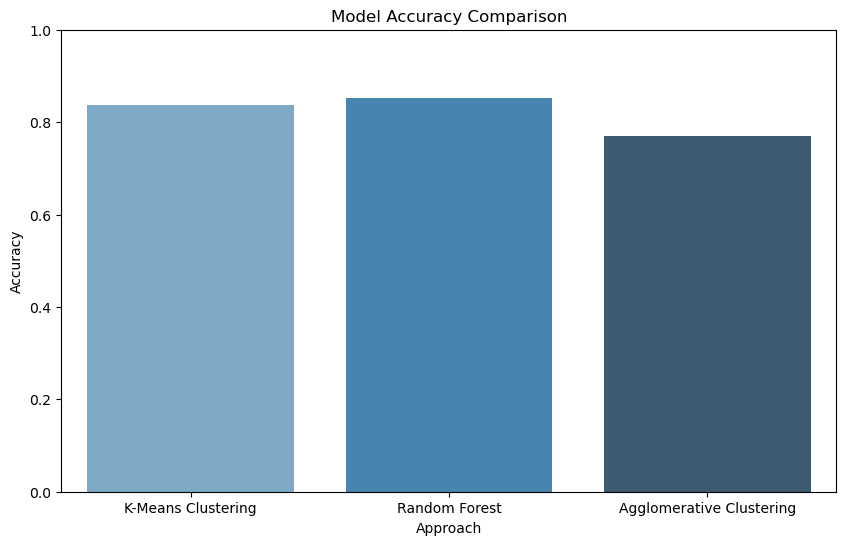

/var/folders/4n/8d9037952j973n4x6lbfj0tw0000gn/T/ipykernel_80402/2561788885.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Approach', y='F1-Score', data=summary, palette='Greens_d')


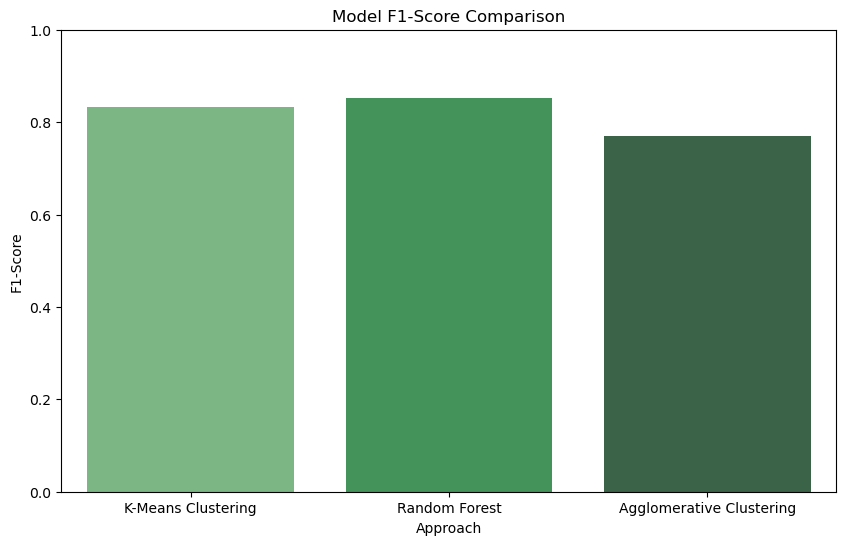

In [445]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Approach', y='Accuracy', data=summary, palette='Blues_d')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Approach', y='F1-Score', data=summary, palette='Greens_d')
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()

Model Improvement / Feature Engineering Improvements

Optimize our Models by combining the 3 into one powerful and more accurate model

In [446]:
def map_clusters_to_classes(cluster_labels, true_labels):
    """
    Maps each cluster to the majority class in that cluster.

    Parameters:
    - cluster_labels: Array-like of cluster assignments.
    - true_labels: Array-like of true class labels.

    Returns:
    - cluster_to_class: Dictionary mapping cluster ID to class label.
    """
    cluster_to_class = {}
    for cluster_id in np.unique(cluster_labels):
        # Convert cluster_id to int to ensure it's a pure Python integer
        cluster_id = int(cluster_id)
        # Get the majority class in each cluster
        majority_class = true_labels[cluster_labels == cluster_id].mode()[0]
        cluster_to_class[cluster_id] = majority_class
    return cluster_to_class


In [447]:
optimal_k = 2  # Assuming binary classification; adjust as needed
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit K-Means on training data and predict cluster labels
train_clusters_kmeans = kmeans.fit_predict(X_train_pca)

# Map K-Means clusters to class labels
cluster_labels_kmeans = map_clusters_to_classes(train_clusters_kmeans, y_train)
print(f"K-Means Cluster to Class Mapping: {cluster_labels_kmeans}")

# Predict clusters for test data
test_clusters_kmeans = kmeans.predict(X_test_pca)

# Map K-Means cluster assignments to class labels
y_pred_kmeans = [cluster_labels_kmeans[int(c)] for c in test_clusters_kmeans]

# Evaluate K-Means Clustering Approach
print("\nClustering Approach (K-Means):")
print("Accuracy:", accuracy_score(y_test, y_pred_kmeans))
print("Classification Report:\n", classification_report(y_test, y_pred_kmeans))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_kmeans))

K-Means Cluster to Class Mapping: {0: 1, 1: 0}

Clustering Approach (K-Means):
Accuracy: 0.819672131147541
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.69      0.77        26
           1       0.80      0.91      0.85        35

    accuracy                           0.82        61
   macro avg       0.83      0.80      0.81        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:
 [[18  8]
 [ 3 32]]


In [448]:
agg_clust = AgglomerativeClustering(n_clusters=2)
# Fit Agglomerative Clustering on training data and predict cluster labels
train_clusters_agg = agg_clust.fit_predict(X_train_pca)
train_clusters_agg = train_clusters_agg.astype(int)  # Ensure integer type

# Map Agglomerative Clustering clusters to class labels
cluster_labels_agg = {}
for cluster_id in np.unique(train_clusters_agg):
    majority_class = y_train[train_clusters_agg == cluster_id].mode()[0]
    cluster_labels_agg[int(cluster_id)] = majority_class

# Calculate centroids of each cluster from training data
centroids_agg = {}
for cluster_id in np.unique(train_clusters_agg):
    centroids_agg[int(cluster_id)] = X_train_pca[train_clusters_agg == cluster_id].mean(axis=0)

# Initialize Nearest Centroid classifier for Agglomerative Clustering
sorted_cluster_ids_agg = sorted(centroids_agg.keys())
centroids_array_agg = np.array([centroids_agg[cid] for cid in sorted_cluster_ids_agg])
class_labels_agg = [cluster_labels_agg[cid] for cid in sorted_cluster_ids_agg]

nearest_centroid_agg = NearestCentroid()
nearest_centroid_agg.centroids_ = centroids_array_agg
nearest_centroid_agg.classes_ = class_labels_agg

# Function to assign cluster based on nearest centroid
def assign_cluster_agg(x, centroids):
    distances = {cid: np.linalg.norm(x - centroid) for cid, centroid in centroids.items()}
    # Ensure the returned cluster ID is an integer
    return int(min(distances, key=distances.get))

# Assign clusters to test data
test_clusters_agg = [assign_cluster_agg(x, centroids_agg) for x in X_test_pca]
test_clusters_agg = [int(c) for c in test_clusters_agg]  # Ensure integer type

# Map cluster assignments to class labels
y_pred_agg = [cluster_labels_agg[c] for c in test_clusters_agg]

# Convert y_pred_agg to a NumPy array before reshaping
y_pred_agg = np.array(y_pred_agg).reshape(-1, 1)

# Evaluate Agglomerative Clustering Approach
print("\nClustering Approach (Agglomerative Clustering):")
print("Accuracy:", accuracy_score(y_test, y_pred_agg))
print("Classification Report:\n", classification_report(y_test, y_pred_agg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_agg))



Clustering Approach (Agglomerative Clustering):
Accuracy: 0.7704918032786885
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.80      0.80      0.80        35

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61

Confusion Matrix:
 [[19  7]
 [ 7 28]]


In [449]:
rf = RandomForestClassifier(random_state=42)

# Ensure that train_clusters_kmeans and train_clusters_agg are NumPy arrays
train_clusters_kmeans = np.array(train_clusters_kmeans).reshape(-1, 1)
train_clusters_agg = np.array(train_clusters_agg).reshape(-1, 1)

# Augment training data with cluster labels
X_train_augmented = np.hstack((X_train_pca, train_clusters_kmeans, train_clusters_agg))

# Train Random Forest on augmented training data
rf.fit(X_train_augmented, y_train)

# Ensure that test_clusters_kmeans and y_pred_agg are NumPy arrays with correct shape
test_clusters_kmeans = np.array(test_clusters_kmeans).reshape(-1, 1)
# y_pred_agg is already a NumPy array with shape (-1, 1) from previous step

# Augment test data with cluster labels
X_test_augmented = np.hstack((X_test_pca, test_clusters_kmeans, y_pred_agg))

# Predict on augmented test data
y_pred_rf_augmented = rf.predict(X_test_augmented)

# Evaluate the augmented Random Forest
print("\nRandom Forest with Augmented Features:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_augmented))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_augmented))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_augmented))


Random Forest with Augmented Features:
Accuracy: 0.8524590163934426
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.77      0.82        26
           1       0.84      0.91      0.88        35

    accuracy                           0.85        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.85      0.85      0.85        61

Confusion Matrix:
 [[20  6]
 [ 3 32]]


In [450]:
y_pred_rf_augmented = np.array(y_pred_rf_augmented).flatten()
y_pred_kmeans = np.array(y_pred_kmeans).flatten()
y_pred_agg = np.array(y_pred_agg).flatten()

# Verify shapes again
print("After flattening:")
print("Shape of y_pred_rf_augmented:", y_pred_rf_augmented.shape)
print("Shape of y_pred_kmeans:", y_pred_kmeans.shape)
print("Shape of y_pred_agg:", y_pred_agg.shape)

After flattening:
Shape of y_pred_rf_augmented: (61,)
Shape of y_pred_kmeans: (61,)
Shape of y_pred_agg: (61,)


In [451]:
from sklearn.ensemble import VotingClassifier

# Since K-Means and Agglomerative Clustering are unsupervised, we'll use their predicted class labels as features
# We'll create a simple Voting Ensemble using the Random Forest and the clustering models' predictions

# Define a function to aggregate predictions
def majority_vote(*args):
    """
    Perform majority voting on predictions.
    
    Parameters:
    - *args: Predictions from different models.
    
    Returns:
    - y_pred: Final predictions after majority voting.
    """
    preds = np.vstack(args).T
    y_pred = []
    for row in preds:
        # Count the occurrences of each class
        counts = np.bincount(row.astype(int))
        # Choose the class with the highest count
        y_pred.append(np.argmax(counts))
    return np.array(y_pred)

# Perform majority voting
y_pred_voting = majority_vote(y_pred_rf_augmented, y_pred_kmeans, y_pred_agg)

# Evaluate Voting Ensemble
print("\nVoting Ensemble:")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Classification Report:\n", classification_report(y_test, y_pred_voting))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_voting))



Voting Ensemble:
Accuracy: 0.819672131147541
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.69      0.77        26
           1       0.80      0.91      0.85        35

    accuracy                           0.82        61
   macro avg       0.83      0.80      0.81        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:
 [[18  8]
 [ 3 32]]


In [452]:
comparison = pd.DataFrame({
    'Model': [
        'Random Forest',
        'K-Means',
        'Agglomerative Clustering',
        'RF + Augmented Features',
        'Voting Ensemble'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_cluster),
        accuracy_score(y_test, y_pred_agg),
        accuracy_score(y_test, y_pred_rf_augmented),
        accuracy_score(y_test, y_pred_voting),
    ]
})

print("\nModel Performance Comparison:")
print(comparison.sort_values(by='Accuracy', ascending=False))



Model Performance Comparison:
                      Model  Accuracy
0             Random Forest  0.852459
3   RF + Augmented Features  0.852459
1                   K-Means  0.836066
4           Voting Ensemble  0.819672
2  Agglomerative Clustering  0.770492


ARM Analysis

In [453]:
df_binary = df.copy()
for col in df_binary.columns:
    # Simple example: binarize based on whether value is above mean or not
    threshold = df_binary[col].mean()
    df_binary[col] = df_binary[col].apply(lambda x: 1 if x > threshold else 0)

# Now df_binary is a dataset with 1/0 indicating "presence" of that feature condition
frequent_itemsets = apriori(df_binary, min_support=0.3, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

print("Frequent Itemsets:")
print(frequent_itemsets.head())

print("\nAssociation Rules:")
print(rules.head())

Frequent Itemsets:
    support  itemsets
0  0.524752     (age)
1  0.683168     (sex)
2  0.528053      (cp)
3  0.435644  (trtbps)
4  0.448845    (chol)

Association Rules:
  antecedents consequents  antecedent support  consequent support   support  \
0       (age)       (sex)            0.524752            0.683168  0.339934   
1        (cp)       (sex)            0.528053            0.683168  0.339934   
2       (sex)   (restecg)            0.683168            0.514851  0.343234   
3   (restecg)       (sex)            0.514851            0.683168  0.343234   
4  (thalachh)       (sex)            0.564356            0.683168  0.363036   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.647799  0.948227 -0.018560    0.899576      -0.103048  
1    0.643750  0.942301 -0.020815    0.889352      -0.114844  
2    0.502415  0.975845 -0.008496    0.975007      -0.072464  
3    0.666667  0.975845 -0.008496    0.950495      -0.048544  
4    0.643275  0.941605 -0.022514    0.

In [454]:
#Filter rules with lift greater than 1
strong_rules = rules[rules['lift'] > 1]
strong_rules = strong_rules.sort_values(by='lift', ascending=False)
strong_rules.reset_index(drop=True, inplace=True)

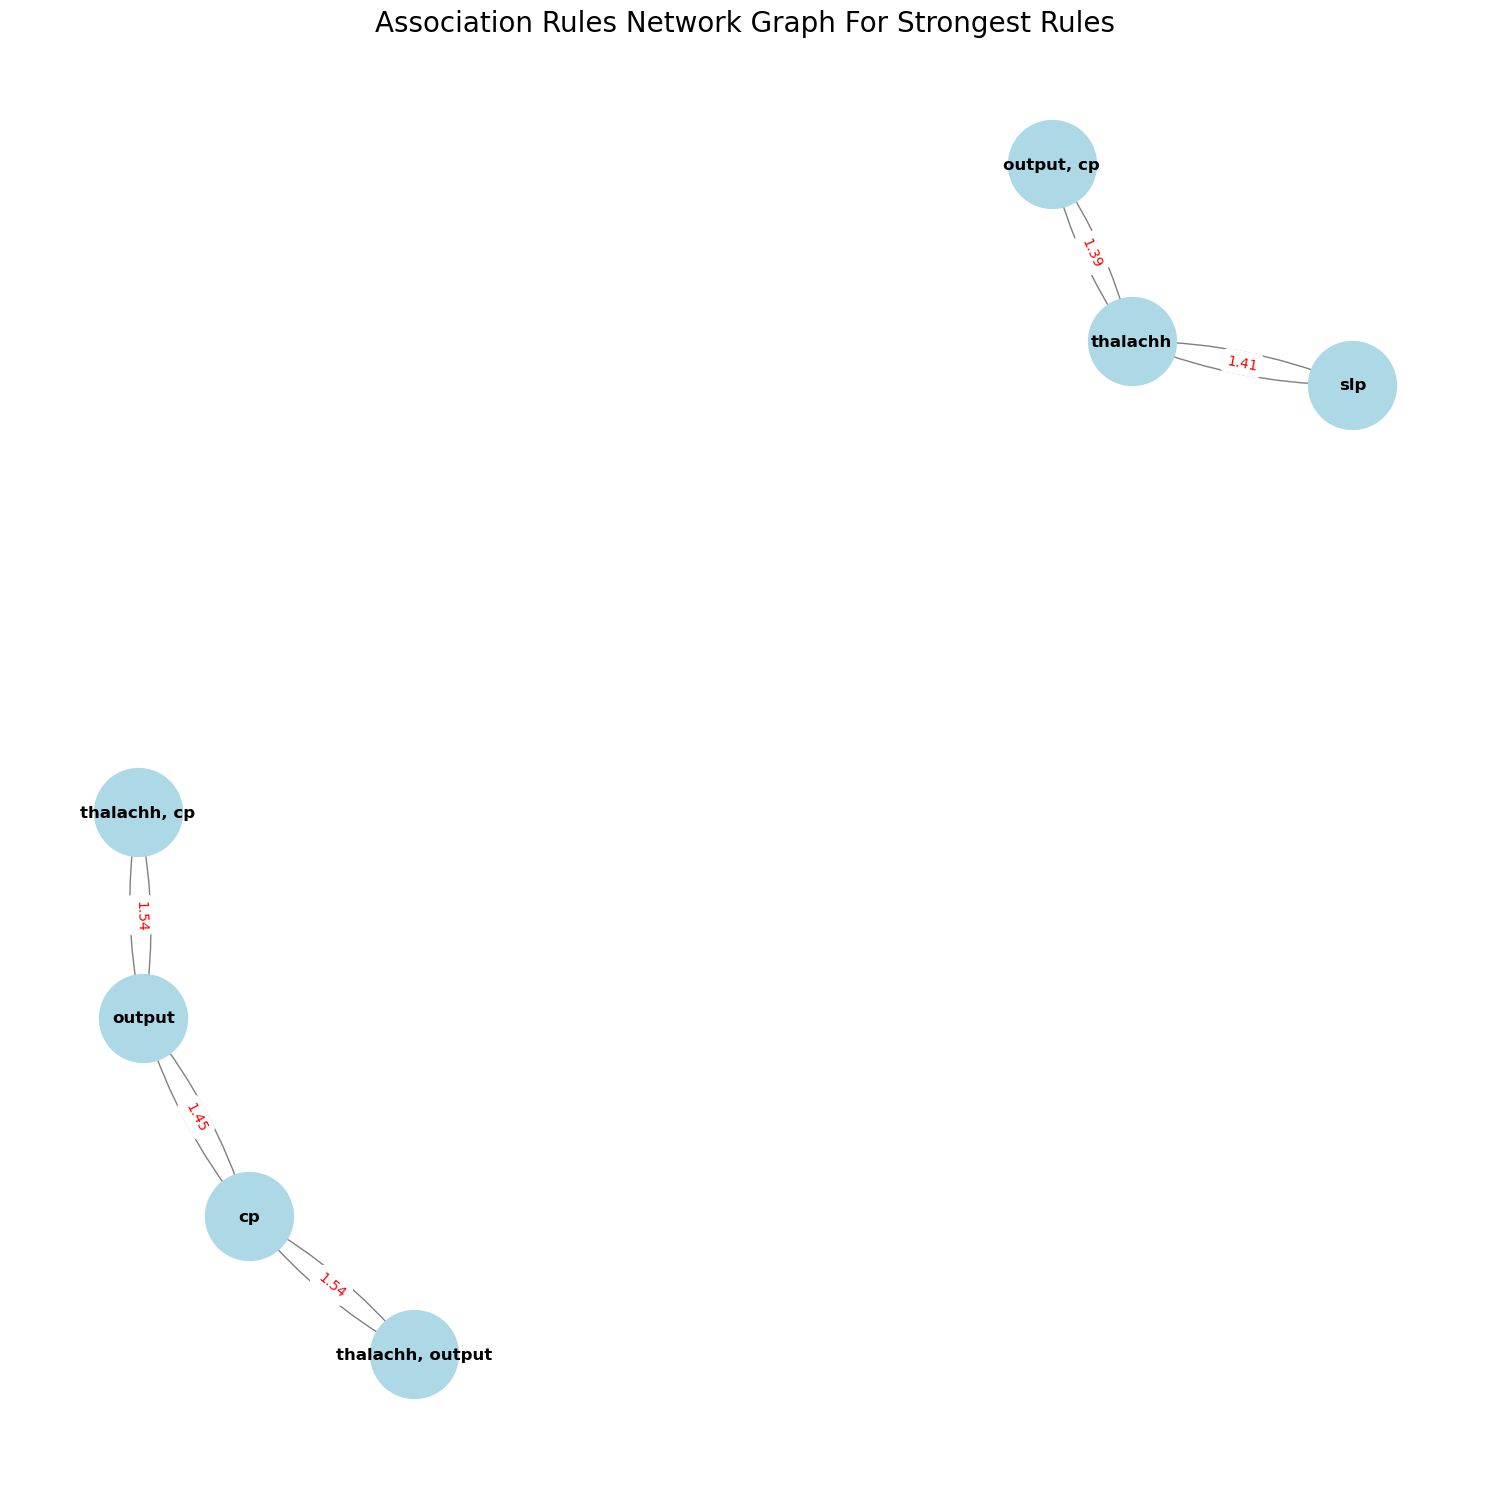

In [456]:
# Visualize Rules
GRAPH_RULES = strong_rules.copy().head(10)

# make all antecedents and consequents as string
GRAPH_RULES['antecedents'] = GRAPH_RULES['antecedents'].apply(lambda x: ', '.join(list(x)))
GRAPH_RULES['consequents'] = GRAPH_RULES['consequents'].apply(lambda x: ', '.join(list(x)))

def insert_newline(x):
    if '_' in x:
        parts = x.rsplit('_', 1)
        return parts[0] + '\n' + parts[1]
    else:
        return x

# Apply the function to antecedents and consequents
GRAPH_RULES['antecedents'] = GRAPH_RULES['antecedents'].apply(insert_newline)
GRAPH_RULES['consequents'] = GRAPH_RULES['consequents'].apply(insert_newline)

# Create a directed graph
G = nx.from_pandas_edgelist(
    df=GRAPH_RULES,
    source='antecedents',
    target='consequents',
    edge_attr=True,
    create_using=nx.DiGraph
)

# Draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.5, seed=1)  # Adjust 'k' for better spacing

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=4000, node_color='lightblue')

# Draw edges
nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle='-|>',
    arrowsize=20,
    edge_color='gray',
    connectionstyle='arc3,rad=0.1'
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw edge labels (lift)
edge_labels = {(u, v): f"{d['lift']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Association Rules Network Graph For Strongest Rules', size=20)
plt.axis('off')
plt.tight_layout()
plt.show()